In [46]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense

In [47]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
except:
    print("Cannot find TPU")
    
if tpu is not None:
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
else:
    strategy = tf.distribute.get_strategy()

Cannot find TPU


In [48]:
FILE_PATH = "/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv"
FEATURES = ["age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status", "stroke"]
CLASS_NAMES = ["safe", "risky"]

VALID_SPLIT = 0.2
EPOCHS = 100

In [49]:
dataset = pd.read_csv(FILE_PATH)
dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [50]:
dataset.drop(columns=["id"], inplace=True)
dataset.dropna(inplace=True)

In [51]:
dataset.loc[dataset["gender"] == "Other", "gender"] = 2
dataset.loc[dataset["gender"] == "Male", "gender"] = 1
dataset.loc[dataset["gender"] == "Female", "gender"] = 0

dataset.loc[dataset["ever_married"] == "Yes", "ever_married"] = 1
dataset.loc[dataset["ever_married"] == "No", "ever_married"] = 0

dataset.loc[dataset["work_type"] == "Never_worked", "work_type"] = 4
dataset.loc[dataset["work_type"] == "children", "work_type"] = 3
dataset.loc[dataset["work_type"] == "Private", "work_type"] = 2
dataset.loc[dataset["work_type"] == "Self-employed", "work_type"] = 1
dataset.loc[dataset["work_type"] == "Govt_job", "work_type"] = 0

dataset.loc[dataset["Residence_type"] == "Urban", "Residence_type"] = 1
dataset.loc[dataset["Residence_type"] == "Rural", "Residence_type"] = 0

dataset.loc[dataset["smoking_status"] == "never smoked", "smoking_status"] = 3
dataset.loc[dataset["smoking_status"] == "formerly smoked", "smoking_status"] = 2
dataset.loc[dataset["smoking_status"] == "smokes", "smoking_status"] = 1
dataset.loc[dataset["smoking_status"] == "Unknown", "smoking_status"] = 0

print(dataset.gender.unique())
print(dataset.ever_married.unique())
print(dataset.work_type.unique())
print(dataset.Residence_type.unique())
print(dataset.smoking_status.unique())

[1 0 2]
[1 0]
[2 1 0 3 4]
[1 0]
[2 3 1 0]


In [52]:
from sklearn.utils import class_weight
print(dataset["stroke"].value_counts())
class_weights = class_weight.compute_class_weight("balanced",
                                                 np.unique(np.array(dataset["stroke"])),
                                                 np.array(dataset["stroke"]))
print(class_weights)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

0    4700
1     209
Name: stroke, dtype: int64
[ 0.52223404 11.74401914]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [53]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,4909.0,42.865374,22.555115,0.08,25.00,44.00,60.00,82.00
hypertension,4909.0,0.091872,0.288875,0.00,0.00,0.00,0.00,1.00
heart_disease,4909.0,0.049501,0.216934,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,4909.0,105.305150,44.424341,55.12,77.07,91.68,113.57,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.50,28.10,33.10,97.60
stroke,4909.0,0.042575,0.201917,0.00,0.00,0.00,0.00,1.00


In [54]:
scaler = MinMaxScaler()
for col in dataset[FEATURES].columns:
    if col != "stroke":
        dataset[col] = scaler.fit_transform(np.array(dataset[col]).reshape(-1, 1))

In [55]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,4909.0,0.522282,0.275331,0.0,0.304199,0.536133,0.731445,1.0
hypertension,4909.0,0.091872,0.288875,0.0,0.000000,0.000000,0.000000,1.0
heart_disease,4909.0,0.049501,0.216934,0.0,0.000000,0.000000,0.000000,1.0
ever_married,4909.0,0.652679,0.476167,0.0,0.000000,1.000000,1.000000,1.0
work_type,4909.0,0.432777,0.217037,0.0,0.250000,0.500000,0.500000,1.0
Residence_type,4909.0,0.507232,0.499999,0.0,0.000000,1.000000,1.000000,1.0
avg_glucose_level,4909.0,0.231674,0.205080,0.0,0.101330,0.168775,0.269827,1.0
bmi,4909.0,0.212981,0.089966,0.0,0.151203,0.203895,0.261168,1.0
smoking_status,4909.0,0.540979,0.420838,0.0,0.000000,0.666667,1.000000,1.0
stroke,4909.0,0.042575,0.201917,0.0,0.000000,0.000000,0.000000,1.0


In [56]:
train_dataset, valid_dataset = train_test_split(dataset, test_size=VALID_SPLIT)

In [57]:
FEATURES = train_dataset.columns[:-1]

def build_model():
    model = Sequential()
    model.add(Dense(len(FEATURES), input_shape=(train_dataset[FEATURES].shape), activation="linear"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(CLASS_NAMES), activation="softmax"))
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    sgd = tf.keras.optimizers.SGD()
    model.compile(loss=loss_function, optimizer=sgd, metrics=["accuracy"])
    return model

In [58]:
with strategy.scope():
    model = build_model()

In [59]:
train_x = np.asarray(train_dataset[FEATURES]).astype('float32')
train_y = np.asarray(train_dataset["stroke"]).astype('float32')
valid_x = np.asarray(valid_dataset[FEATURES]).astype('float32')
valid_y = np.asarray(valid_dataset["stroke"]).astype('float32')

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    validation_data=(valid_x, valid_y),
                    class_weight=class_weights
                    )

Epoch 1/100
123/123 [==============================] - 1s 3ms/step - loss: 0.6851 - accuracy: 0.5999 - val_loss: 0.7443 - val_accuracy: 0.3442
Epoch 2/100
123/123 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.3833 - val_loss: 0.7047 - val_accuracy: 0.4155
Epoch 3/100
123/123 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.4136 - val_loss: 0.6795 - val_accuracy: 0.4491
Epoch 4/100
123/123 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.5056 - val_loss: 0.7035 - val_accuracy: 0.4348
Epoch 5/100
123/123 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.5000 - val_loss: 0.6762 - val_accuracy: 0.4654
Epoch 6/100
123/123 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.5126 - val_loss: 0.6351 - val_accuracy: 0.5295
Epoch 7/100
123/123 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.5764 - val_loss: 0.6029 - val_accuracy: 0.5947

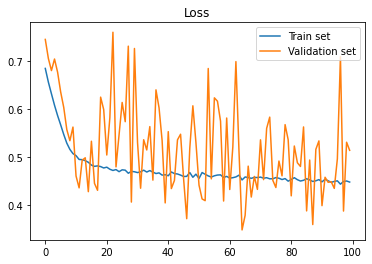

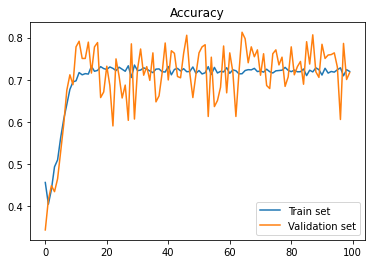

In [60]:
#Train set data
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

#Validation set data
val_loss_curve = history.history["val_loss"]
val_acc_curve = history.history["val_accuracy"]

#Loss plot
plt.plot(loss_curve, label="Train set")
plt.plot(val_loss_curve, label="Validation set")
plt.legend(loc='upper right')
plt.title("Loss")
plt.show()

#Accuracy plot
plt.plot(acc_curve, label="Train set")
plt.plot(val_acc_curve, label="Validation set")
plt.legend(loc='lower right')
plt.title("Accuracy")
plt.show()